In [1]:
! pip install transformers datasets evaluate seqeval
! pip install -U accelerate
! pip install -U transformers

Importando bibliotecas

In [2]:
import numpy as np
import os 
import pandas as pd
import datasets
import torch
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import evaluate
from transformers import AutoModelForTokenClassification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Leitura do dataset

In [3]:
dataset = datasets.load_from_disk("../dataset")

Info do dataset

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 7828
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1177
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1390
    })
})

In [5]:
print(dataset['train'].description)


LeNER-Br is a Portuguese language dataset for named entity recognition
applied to legal documents. LeNER-Br consists entirely of manually annotated
legislation and legal cases texts and contains tags for persons, locations,
time entities, organizations, legislation and legal cases.
To compose the dataset, 66 legal documents from several Brazilian Courts were
collected. Courts of superior and state levels were considered, such as Supremo
Tribunal Federal, Superior Tribunal de Justiça, Tribunal de Justiça de Minas
Gerais and Tribunal de Contas da União. In addition, four legislation documents
were collected, such as "Lei Maria da Penha", giving a total of 70 documents



In [6]:
df_train = pd.DataFrame(dataset['train'])
df_validation = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

In [7]:
df_train[df_train['tokens'].apply(lambda x: len(x) == 0)]

id tokens ner_tags
7827  7827     []       []

Removendo linhas que não deveriam estar no dataset

In [8]:
df_train = df_train[df_train['tokens'].apply(lambda x: len(x) > 0)]
df_validation = df_validation[df_validation['tokens'].apply(lambda x: len(x) > 0)]
df_test = df_test[df_test['tokens'].apply(lambda x: len(x) > 0)]

Lendo tokenizer do modelo original

In [9]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

Função utilizada para alinhar labels durante finetune

In [10]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [11]:
label_list = dataset['train'].features['ner_tags'].feature.names
label_list

['O',
 'B-ORGANIZACAO',
 'I-ORGANIZACAO',
 'B-PESSOA',
 'I-PESSOA',
 'B-TEMPO',
 'I-TEMPO',
 'B-LOCAL',
 'I-LOCAL',
 'B-LEGISLACAO',
 'I-LEGISLACAO',
 'B-JURISPRUDENCIA',
 'I-JURISPRUDENCIA']

In [12]:
id2label = {
    0: "sem label",
    1: "B-ORGANIZACAO",
    2: "I-ORGANIZACAO",
    3: "B-PESSOA",
    4: "I-PESSOA",
    5: "B-TEMPO",
    6: "I-TEMPO",
    7: "B-LOCAL",
    8: "I-LOCAL",
    9: "B-LEGISLACAO",
    10: "I-LEGISLACAO",
    11: "B-JURISPRUDENCIA",
    12: "I-JURISPRUDENCIA"
}

In [13]:
label2id = {
    "sem label": 0,
    "B-ORGANIZACAO": 1,
    "I-ORGANIZACAO": 2,
    "B-PESSOA": 3,
    "I-PESSOA": 4,
    "B-TEMPO": 5,
    "I-TEMPO": 6,
    "B-LOCAL": 7,
    "I-LOCAL": 8,
    "B-LEGISLACAO": 9,
    "I-LEGISLACAO": 10,
    "B-JURISPRUDENCIA": 11,
    "I-JURISPRUDENCIA": 12
}

Convertendo pandas para dataset para aplicar função novamente nos dados de teste

In [14]:
df_test = Dataset.from_pandas(df_test)
df_test = df_test.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/1389 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Remover colunas desnecessárias

In [15]:
df_test = pd.DataFrame(df_test)
df_test = df_test.drop(['__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'], axis = 1)
df_test.head()

id                                             tokens   
0  0  [Número, do, Acórdão, ACÓRDÃO, 1160/2016, -, P...  \
1  1  [Interessado, /, Responsável, /, Recorrente, 3...   
2  2  [Interessados/Responsáveis/Recorrentes, :, 3.1...   
3  3  [Interessado, :, Superior, Tribunal, Militar, ...   
4  4  [Responsáveis, :, Aldo, da, Silva, Fagundes, (...   

                                            ner_tags   
0  [0, 0, 0, 11, 12, 0, 1, 0, 3, 4, 11, 12, 0, 0,...  \
1                              [0, 0, 0, 0, 0, 0, 0]   
2                                       [0, 0, 0, 0]   
3                     [0, 0, 1, 2, 2, 0, 0, 0, 0, 0]   
4  [0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 4, 0, ...   

                                              labels  
0  [-100, 0, -100, 0, 0, -100, -100, 11, -100, -1...  
1  [-100, 0, -100, -100, 0, 0, -100, -100, -100, ...  
2  [-100, 0, -100, -100, -100, -100, -100, -100, ...  
3  [-100, 0, -100, -100, 0, 1, 2, 2, 0, 0, -100, ...  
4  [-100, 0, -100, -100, -100, 0, 3, -100, 4, 4, ...

Ler modelo finetuned

In [16]:
model_name = "bertimbau-base-lener-br"
num_labels = 13
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels = num_labels)

Criar preditor customizado

In [17]:
def classifier(text):
    inputs = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt')
    outputs = model(**inputs)

    predicted_labels = torch.argmax(outputs.logits, dim=2)[0]
    scores = torch.softmax(outputs.logits, dim=2)[0]

    entities = []
    for idx, label_id in enumerate(predicted_labels):

        label = id2label[label_id.item()]
        score = scores[idx][label_id].item()
        entity = {
            'entity': label,
            'score': score,
            'index': idx,
            'word': tokenizer.convert_ids_to_tokens(inputs.input_ids[0][idx].item()),
        }
        entities.append(entity)

    return entities


Aplicar preditor no primeiro id dos dados de teste

In [18]:
exemplo = " ".join(df_test['tokens'][0])
exemplo

'Número do Acórdão ACÓRDÃO 1160/2016 - PLENÁRIO Relator AUGUSTO NARDES Processo 006.010/2000-4 Tipo de processo TOMADA DE CONTAS SIMPLIFICADA ( TCSP ) Data da sessão 11/05/2016 Número da ata 16/2016 Relator da deliberação recorrida Ministra Ana Arraes .'

In [19]:
classifier(exemplo)

[{'entity': 'sem label',
  'score': 0.9920294284820557,
  'index': 0,
  'word': '[CLS]'},
 {'entity': 'sem label',
  'score': 0.9998797178268433,
  'index': 1,
  'word': 'Nú'},
 {'entity': 'sem label',
  'score': 0.9999188184738159,
  'index': 2,
  'word': '##mero'},
 {'entity': 'sem label',
  'score': 0.9999730587005615,
  'index': 3,
  'word': 'do'},
 {'entity': 'sem label', 'score': 0.999942421913147, 'index': 4, 'word': 'Ac'},
 {'entity': 'sem label',
  'score': 0.9998331069946289,
  'index': 5,
  'word': '##ór'},
 {'entity': 'sem label',
  'score': 0.9999531507492065,
  'index': 6,
  'word': '##dão'},
 {'entity': 'B-JURISPRUDENCIA',
  'score': 0.9996728897094727,
  'index': 7,
  'word': 'AC'},
 {'entity': 'B-JURISPRUDENCIA',
  'score': 0.9996583461761475,
  'index': 8,
  'word': '##Ó'},
 {'entity': 'B-JURISPRUDENCIA',
  'score': 0.9996384382247925,
  'index': 9,
  'word': '##R'},
 {'entity': 'B-JURISPRUDENCIA',
  'score': 0.999663233757019,
  'index': 10,
  'word': '##D'},
 {'enti

Vemos que novamente há os caracteres especiais e a separação de palavras

Criar predição nos dados de teste

In [20]:
df_test['predicted_tags'] = None  

for index, row in df_test.iterrows():
    tokens = row["tokens"]
    text = " ".join(tokens)
    predictions = []

    # Separar texto em chunks de 512 caracteres, por limitação do BERT base
    max_length = 512
    chunks = [text[i:i+max_length] for i in range(0, len(text), max_length)]

    for chunk in chunks:
        chunk_predictions = classifier(chunk)
        predictions.extend(chunk_predictions)

    predicted_tags = [pred["entity"] for pred in predictions]
    # Atribuir previsão
    df_test.at[index, 'predicted_tags'] = predicted_tags  
    
# Visualizar dados de teste
df_test.head()

id                                             tokens   
0  0  [Número, do, Acórdão, ACÓRDÃO, 1160/2016, -, P...  \
1  1  [Interessado, /, Responsável, /, Recorrente, 3...   
2  2  [Interessados/Responsáveis/Recorrentes, :, 3.1...   
3  3  [Interessado, :, Superior, Tribunal, Militar, ...   
4  4  [Responsáveis, :, Aldo, da, Silva, Fagundes, (...   

                                            ner_tags   
0  [0, 0, 0, 11, 12, 0, 1, 0, 3, 4, 11, 12, 0, 0,...  \
1                              [0, 0, 0, 0, 0, 0, 0]   
2                                       [0, 0, 0, 0]   
3                     [0, 0, 1, 2, 2, 0, 0, 0, 0, 0]   
4  [0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 4, 0, ...   

                                              labels   
0  [-100, 0, -100, 0, 0, -100, -100, 11, -100, -1...  \
1  [-100, 0, -100, -100, 0, 0, -100, -100, -100, ...   
2  [-100, 0, -100, -100, -100, -100, -100, -100, ...   
3  [-100, 0, -100, -100, 0, 1, 2, 2, 0, 0, -100, ...   
4  [-100, 0, -100, -100, -100, 0, 3, -100, 4, 4, ...   

                                      predicted_tags  
0  [sem label, sem label, sem label, sem label, s...  
1  [sem label, sem label, sem label, sem label, s...  
2  [sem label, sem label, sem label, sem label, s...  
3  [sem label, sem label, sem label, sem label, s...  
4  [sem label, sem label, sem label, sem label, s...

Verificar se tamanho está condizente. Vemos que, para o id 0, por exemplo, temos 99 tags previstas, o que está igual com o número de tokens previstos ao aplicar o tokenizer (tokenize and align labels). O número de tags ground truth é 38, e a diferença é exatamente o número de tokens que foram atribuídos labels "-100".

In [21]:
df_test['count_neg_100'] = df_test['labels'].apply(lambda x: sum(1 for label in x if label == -100))
df_test['count_labels'] = df_test['labels'].apply(lambda x: len(x))
df_test['count_predicted'] = df_test['predicted_tags'].apply(lambda x: len(x))
df_test['count_tags'] = df_test['ner_tags'].apply(lambda x: len(x))
df_test.head()

id                                             tokens   
0  0  [Número, do, Acórdão, ACÓRDÃO, 1160/2016, -, P...  \
1  1  [Interessado, /, Responsável, /, Recorrente, 3...   
2  2  [Interessados/Responsáveis/Recorrentes, :, 3.1...   
3  3  [Interessado, :, Superior, Tribunal, Militar, ...   
4  4  [Responsáveis, :, Aldo, da, Silva, Fagundes, (...   

                                            ner_tags   
0  [0, 0, 0, 11, 12, 0, 1, 0, 3, 4, 11, 12, 0, 0,...  \
1                              [0, 0, 0, 0, 0, 0, 0]   
2                                       [0, 0, 0, 0]   
3                     [0, 0, 1, 2, 2, 0, 0, 0, 0, 0]   
4  [0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 4, 0, ...   

                                              labels   
0  [-100, 0, -100, 0, 0, -100, -100, 11, -100, -1...  \
1  [-100, 0, -100, -100, 0, 0, -100, -100, -100, ...   
2  [-100, 0, -100, -100, -100, -100, -100, -100, ...   
3  [-100, 0, -100, -100, 0, 1, 2, 2, 0, 0, -100, ...   
4  [-100, 0, -100, -100, -100, 0, 3, -100, 4, 4, ...   

                                      predicted_tags  count_neg_100   
0  [sem label, sem label, sem label, sem label, s...             61  \
1  [sem label, sem label, sem label, sem label, s...              9   
2  [sem label, sem label, sem label, sem label, s...             15   
3  [sem label, sem label, sem label, sem label, s...             17   
4  [sem label, sem label, sem label, sem label, s...             88   

   count_labels  count_predicted  count_tags  
0            99               99          38  
1            16               16           7  
2            19               19           4  
3            27               27          10  
4           156              156          68

Remover tags com -100 (caracteres especiais e meio de palavras)

In [22]:
for index, row in df_test.iterrows():
    predicted_tags = row["predicted_tags"]
    labels = row["labels"]
    filtered_predicted_tags = [tag for tag, label in zip(predicted_tags, labels) if label != -100]
    df_test.at[index, "predicted_tags"] = filtered_predicted_tags

df_test = df_test.drop(['labels','count_neg_100','count_labels','count_predicted', 'count_tags'], axis = 1)
df_test.head()

id                                             tokens   
0  0  [Número, do, Acórdão, ACÓRDÃO, 1160/2016, -, P...  \
1  1  [Interessado, /, Responsável, /, Recorrente, 3...   
2  2  [Interessados/Responsáveis/Recorrentes, :, 3.1...   
3  3  [Interessado, :, Superior, Tribunal, Militar, ...   
4  4  [Responsáveis, :, Aldo, da, Silva, Fagundes, (...   

                                            ner_tags   
0  [0, 0, 0, 11, 12, 0, 1, 0, 3, 4, 11, 12, 0, 0,...  \
1                              [0, 0, 0, 0, 0, 0, 0]   
2                                       [0, 0, 0, 0]   
3                     [0, 0, 1, 2, 2, 0, 0, 0, 0, 0]   
4  [0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 4, 0, ...   

                                      predicted_tags  
0  [sem label, sem label, sem label, B-JURISPRUDE...  
1  [sem label, sem label, sem label, sem label, s...  
2       [sem label, sem label, sem label, sem label]  
3  [sem label, sem label, B-ORGANIZACAO, I-ORGANI...  
4  [sem label, sem label, B-PESSOA, I-PESSOA, I-P...

Criar tupla com id, posições iniciais e finais do caracter e tag, para ground truth e predição

In [23]:
def true_labels(data):
    labels = []
    for _, row in data.iterrows():
        id = row['id']
        tokens = row['tokens']
        ner_tags = row['ner_tags']
        label = [
            (   
                row['id'],
                sum(len(word) + 1 for word in tokens[:i]), 
                sum(len(word) + 1 for word in tokens[:i+1]) - 1, 
                id2label.get(tag, "sem label")  
            )
            for i, tag in enumerate(ner_tags)
        ]
        labels.append(label)
    return labels

print(true_labels(df_test))

[[('0', 0, 6, 'sem label'), ('0', 7, 9, 'sem label'), ('0', 10, 17, 'sem label'), ('0', 18, 25, 'B-JURISPRUDENCIA'), ('0', 26, 35, 'I-JURISPRUDENCIA'), ('0', 36, 37, 'sem label'), ('0', 38, 46, 'B-ORGANIZACAO'), ('0', 47, 54, 'sem label'), ('0', 55, 62, 'B-PESSOA'), ('0', 63, 69, 'I-PESSOA'), ('0', 70, 78, 'B-JURISPRUDENCIA'), ('0', 79, 93, 'I-JURISPRUDENCIA'), ('0', 94, 98, 'sem label'), ('0', 99, 101, 'sem label'), ('0', 102, 110, 'sem label'), ('0', 111, 117, 'sem label'), ('0', 118, 120, 'sem label'), ('0', 121, 127, 'sem label'), ('0', 128, 140, 'sem label'), ('0', 141, 142, 'sem label'), ('0', 143, 147, 'sem label'), ('0', 148, 149, 'sem label'), ('0', 150, 154, 'sem label'), ('0', 155, 157, 'sem label'), ('0', 158, 164, 'sem label'), ('0', 165, 175, 'B-TEMPO'), ('0', 176, 182, 'sem label'), ('0', 183, 185, 'sem label'), ('0', 186, 189, 'sem label'), ('0', 190, 197, 'sem label'), ('0', 198, 205, 'sem label'), ('0', 206, 208, 'sem label'), ('0', 209, 220, 'sem label'), ('0', 221, 

In [24]:
def predicted_labels(data):
    labels = []
    for _, row in data.iterrows():
        id = row['id']
        tokens = row['tokens']
        predicted_tags = row['predicted_tags']
        label = [
            (   
                row['id'],
                sum(len(word) + 1 for word in tokens[:i]),  # Start position of the entity
                sum(len(word) + 1 for word in tokens[:i+1]) - 1,  # End position of the entity
                tag   # Label of the entity
            )
            for i, tag in enumerate(predicted_tags)
        ]
        labels.append(label)
    return labels


print(predicted_labels(df_test))

[[('0', 0, 6, 'sem label'), ('0', 7, 9, 'sem label'), ('0', 10, 17, 'sem label'), ('0', 18, 25, 'B-JURISPRUDENCIA'), ('0', 26, 35, 'I-JURISPRUDENCIA'), ('0', 36, 37, 'sem label'), ('0', 38, 46, 'B-ORGANIZACAO'), ('0', 47, 54, 'sem label'), ('0', 55, 62, 'B-PESSOA'), ('0', 63, 69, 'I-PESSOA'), ('0', 70, 78, 'B-JURISPRUDENCIA'), ('0', 79, 93, 'I-JURISPRUDENCIA'), ('0', 94, 98, 'sem label'), ('0', 99, 101, 'sem label'), ('0', 102, 110, 'sem label'), ('0', 111, 117, 'sem label'), ('0', 118, 120, 'sem label'), ('0', 121, 127, 'sem label'), ('0', 128, 140, 'sem label'), ('0', 141, 142, 'sem label'), ('0', 143, 147, 'sem label'), ('0', 148, 149, 'sem label'), ('0', 150, 154, 'sem label'), ('0', 155, 157, 'sem label'), ('0', 158, 164, 'sem label'), ('0', 165, 175, 'B-TEMPO'), ('0', 176, 182, 'sem label'), ('0', 183, 185, 'sem label'), ('0', 186, 189, 'sem label'), ('0', 190, 197, 'sem label'), ('0', 198, 205, 'sem label'), ('0', 206, 208, 'sem label'), ('0', 209, 220, 'sem label'), ('0', 221, 

Adicionar tuplas ao dataframe

In [25]:
df_test['true_labels'] = true_labels(df_test)
df_test['predicted_labels'] = predicted_labels(df_test)

In [26]:
df_test.head()

id                                             tokens   
0  0  [Número, do, Acórdão, ACÓRDÃO, 1160/2016, -, P...  \
1  1  [Interessado, /, Responsável, /, Recorrente, 3...   
2  2  [Interessados/Responsáveis/Recorrentes, :, 3.1...   
3  3  [Interessado, :, Superior, Tribunal, Militar, ...   
4  4  [Responsáveis, :, Aldo, da, Silva, Fagundes, (...   

                                            ner_tags   
0  [0, 0, 0, 11, 12, 0, 1, 0, 3, 4, 11, 12, 0, 0,...  \
1                              [0, 0, 0, 0, 0, 0, 0]   
2                                       [0, 0, 0, 0]   
3                     [0, 0, 1, 2, 2, 0, 0, 0, 0, 0]   
4  [0, 0, 3, 4, 4, 4, 0, 0, 0, 0, 3, 4, 4, 4, 0, ...   

                                      predicted_tags   
0  [sem label, sem label, sem label, B-JURISPRUDE...  \
1  [sem label, sem label, sem label, sem label, s...   
2       [sem label, sem label, sem label, sem label]   
3  [sem label, sem label, B-ORGANIZACAO, I-ORGANI...   
4  [sem label, sem label, B-PESSOA, I-PESSOA, I-P...   

                                         true_labels   
0  [(0, 0, 6, sem label), (0, 7, 9, sem label), (...  \
1  [(1, 0, 11, sem label), (1, 12, 13, sem label)...   
2  [(2, 0, 37, sem label), (2, 38, 39, sem label)...   
3  [(3, 0, 11, sem label), (3, 12, 13, sem label)...   
4  [(4, 0, 12, sem label), (4, 13, 14, sem label)...   

                                    predicted_labels  
0  [(0, 0, 6, sem label), (0, 7, 9, sem label), (...  
1  [(1, 0, 11, sem label), (1, 12, 13, sem label)...  
2  [(2, 0, 37, sem label), (2, 38, 39, sem label)...  
3  [(3, 0, 11, sem label), (3, 12, 13, sem label)...  
4  [(4, 0, 12, sem label), (4, 13, 14, sem label)...

Convertendo para listas e criando vetores ground truth e predição para visualizar resultados

In [27]:
all_true_labels = []
for tuples_list in df_test['true_labels']:
    for label_tuple in tuples_list:
        all_true_labels.append(label_tuple)

all_predicted_labels = []
for tuples_list in df_test['predicted_labels']:
    for label_tuple in tuples_list:
        all_predicted_labels.append(label_tuple)

# Print the resulting list of tuples
print(all_true_labels)
print(all_predicted_labels)
len(all_true_labels), len(all_predicted_labels)

[('0', 0, 6, 'sem label'), ('0', 7, 9, 'sem label'), ('0', 10, 17, 'sem label'), ('0', 18, 25, 'B-JURISPRUDENCIA'), ('0', 26, 35, 'I-JURISPRUDENCIA'), ('0', 36, 37, 'sem label'), ('0', 38, 46, 'B-ORGANIZACAO'), ('0', 47, 54, 'sem label'), ('0', 55, 62, 'B-PESSOA'), ('0', 63, 69, 'I-PESSOA'), ('0', 70, 78, 'B-JURISPRUDENCIA'), ('0', 79, 93, 'I-JURISPRUDENCIA'), ('0', 94, 98, 'sem label'), ('0', 99, 101, 'sem label'), ('0', 102, 110, 'sem label'), ('0', 111, 117, 'sem label'), ('0', 118, 120, 'sem label'), ('0', 121, 127, 'sem label'), ('0', 128, 140, 'sem label'), ('0', 141, 142, 'sem label'), ('0', 143, 147, 'sem label'), ('0', 148, 149, 'sem label'), ('0', 150, 154, 'sem label'), ('0', 155, 157, 'sem label'), ('0', 158, 164, 'sem label'), ('0', 165, 175, 'B-TEMPO'), ('0', 176, 182, 'sem label'), ('0', 183, 185, 'sem label'), ('0', 186, 189, 'sem label'), ('0', 190, 197, 'sem label'), ('0', 198, 205, 'sem label'), ('0', 206, 208, 'sem label'), ('0', 209, 220, 'sem label'), ('0', 221, 2

(47630, 47630)

In [28]:
y_true = [label for _, _, _, label in all_true_labels]
y_pred = [label for _, _, _, label in all_predicted_labels]

Resultados

In [29]:
print('\nClassification Report')
print(classification_report(y_true, y_pred))


Classification Report
                  precision    recall  f1-score   support

B-JURISPRUDENCIA       0.74      0.86      0.80       185
    B-LEGISLACAO       0.88      0.89      0.88       378
         B-LOCAL       0.61      0.72      0.66        47
   B-ORGANIZACAO       0.75      0.79      0.77       501
        B-PESSOA       0.90      0.93      0.91       233
         B-TEMPO       0.80      0.84      0.82       192
I-JURISPRUDENCIA       0.84      0.81      0.82       475
    I-LEGISLACAO       0.93      0.94      0.93      2291
         I-LOCAL       0.48      0.69      0.56        85
   I-ORGANIZACAO       0.78      0.79      0.79       866
        I-PESSOA       0.92      0.94      0.93       502
         I-TEMPO       0.92      0.96      0.94        68
       sem label       0.99      0.99      0.99     41807

        accuracy                           0.97     47630
       macro avg       0.81      0.86      0.83     47630
    weighted avg       0.97      0.97      0.97

In [30]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        # change category codes or labels to new labels 
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    # calculate a confusion matrix with the new labels
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    # calculate row sums (for calculating % & plot annotations)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    # calculate proportions
    cm_perc = cm / cm_sum.astype(float) * 100
    # empty array for holding annotations for each cell in the heatmap
    annot = np.empty_like(cm).astype(str)
    # get the dimensions
    nrows, ncols = cm.shape
    # cycle over cells and create annotations for each cell
    for i in range(nrows):
        for j in range(ncols):
            # get the count for the cell
            c = cm[i, j]
            # get the percentage for the cell
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                # convert the proportion, count, and row sum to a string with pretty formatting
                annot[i, j] = '%d\n%.1f%%' % (c,p)
            elif c == 0:
                annot[i, j] = '%d' % (c)
            else:
                annot[i, j] = '%d\n%.1f%%' % (c,p)
    # convert the array to a dataframe. To plot by proportion instead of number, use cm_perc in the DataFrame instead of cm
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Verdadeiro'
    cm.columns.name = 'Predição'
    # create empty figure with a specified size
    fig, ax = plt.subplots(figsize=figsize)
    # plot the data using the Pandas dataframe. To change the color map, add cmap=..., e.g. cmap = 'rocket_r'
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap = 'rocket_r')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    #plt.savefig(filename)
    plt.show()


In [31]:
full_entities_list = sorted(list(set(id2label.values())))
entities_list = [item for item in full_entities_list if item != 'sem label']
np.array(full_entities_list), np.array(entities_list)

(array(['B-JURISPRUDENCIA', 'B-LEGISLACAO', 'B-LOCAL', 'B-ORGANIZACAO',
        'B-PESSOA', 'B-TEMPO', 'I-JURISPRUDENCIA', 'I-LEGISLACAO',
        'I-LOCAL', 'I-ORGANIZACAO', 'I-PESSOA', 'I-TEMPO', 'sem label'],
       dtype='<U16'),
 array(['B-JURISPRUDENCIA', 'B-LEGISLACAO', 'B-LOCAL', 'B-ORGANIZACAO',
        'B-PESSOA', 'B-TEMPO', 'I-JURISPRUDENCIA', 'I-LEGISLACAO',
        'I-LOCAL', 'I-ORGANIZACAO', 'I-PESSOA', 'I-TEMPO'], dtype='<U16'))

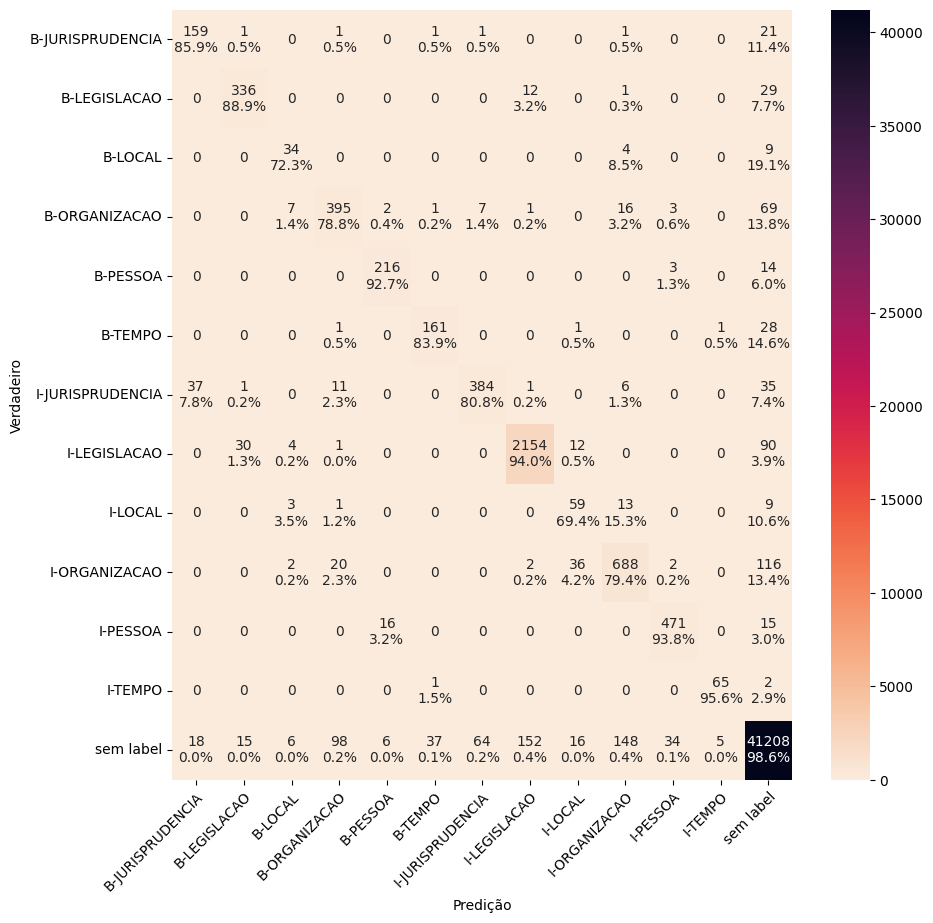

In [32]:
cm_analysis(y_true, y_pred, full_entities_list)

In [33]:
modified_y_true = [label[2:] if label.startswith("B-") or label.startswith("I-") else label for label in y_true]
modified_y_pred = [label[2:] if label.startswith("B-") or label.startswith("I-") else label for label in y_pred]
entities_list = np.unique(modified_y_true)
entities_list = [item for item in entities_list if item != 'sem label']

In [34]:
print('\nClassification Report')
print(classification_report(modified_y_true, modified_y_pred, labels = entities_list))


Classification Report
                precision    recall  f1-score   support

JURISPRUDENCIA       0.87      0.88      0.87       660
    LEGISLACAO       0.94      0.95      0.94      2669
         LOCAL       0.53      0.73      0.62       132
   ORGANIZACAO       0.80      0.82      0.81      1367
        PESSOA       0.94      0.96      0.95       735
         TEMPO       0.84      0.88      0.86       260

     micro avg       0.88      0.90      0.89      5823
     macro avg       0.82      0.87      0.84      5823
  weighted avg       0.88      0.90      0.89      5823

